# Import necessary packages

In [1]:
import math
import numpy as np 
from numpy.linalg import inv
import matplotlib.pyplot as plt
import openpyxl
import cmath
import graphviz
from array import array

import qiskit as q
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import *
from qiskit.quantum_info import Pauli, SparsePauliOp, Operator
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import *
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator, SamplerV2 as Sampler

# Connect to ibm select the device to mimic the error

In [2]:
# Save an IBM Quantum account and set it as your default account.
API_Token = '13d9540e280b61b7a4254fcdb05516180957df07523dfef1924f7d9363699a51826b42e7a063b3fb685f295f6d27f8ff61810a97f503a704c07bc959d6cc6e3f'
QiskitRuntimeService.save_account(
    channel = "ibm_quantum",
    
    instance ='ibm-q-hub-ntu/chen-hong-bin/default',
    token = API_Token,
    set_as_default = True,
    # Use `overwrite=True` if you're updating your token.
    overwrite = True,
)

In [3]:
# # # Load saved credentials
# # service = QiskitRuntimeService()

# # #For real Device
# # device = service.backend("ibm_kyiv")
# # noise_model = NoiseModel.from_backend(device)

# # Get basis gates from noise model
# basis_gates = noise_model.basis_gates

# # Get coupling map from backend
# coupling_map = [[0, 1], [1, 2], [3, 2], [3, 4]]

# #For Aer
# # backend = AerSimulator(noise_model=noise_model,
# #                        coupling_map=coupling_map,
# #                        basis_gates=basis_gates)
# backend = AerSimulator()

# backendqubitNum = backend.num_qubits
# print(backendqubitNum)

In [4]:
# 建立空的 noise model
noise_model = NoiseModel()

# 加入 CNOT gate 的 depolarizing noise（以 (0,1) 為例）
cx_error = depolarizing_error(param=0.05, num_qubits=2)  # 1% depolarizing error
noise_model.add_quantum_error(cx_error, 'cx', [0, 1])

# 加入 measurement 的 readout error（以 qubit 0 為例）
readout_probs = [[0.95, 0.05], [0.02, 0.98]]  # 機率轉換矩陣
readout_error = ReadoutError(readout_probs)
noise_model.add_readout_error(readout_error, [0])
noise_model.add_readout_error(readout_error, [1])

# 設定模擬器
backend = AerSimulator(noise_model=noise_model)
backendqubitNum = backend.num_qubits
print(backendqubitNum)

34


In [5]:
print("=== All gate errors in the noise model ===")
for (gate, qubits), errors in noise_model._local_quantum_errors.items():
    print(f"Gate: {gate}, Qubits: {qubits}")
    for err in errors:
        print(err)

print("\n=== All readout errors in the noise model ===")
for qubits, err in noise_model._local_readout_errors.items():
    print(f"Qubits: {qubits}, Error: {err}")


=== All gate errors in the noise model ===
Gate: c, Qubits: x
(0, 1)

=== All readout errors in the noise model ===
Qubits: (0,), Error: ReadoutError on 1 qubits. Assignment probabilities:
 P(j|0) =  [0.95 0.05]
 P(j|1) =  [0.02 0.98]
Qubits: (1,), Error: ReadoutError on 1 qubits. Assignment probabilities:
 P(j|0) =  [0.95 0.05]
 P(j|1) =  [0.02 0.98]


# Do 2-qubits measurement PEC

In [6]:
#Build Four Initial State |0>, |1>, |0>+|1>, |0>-i|1>
qreg = QuantumRegister(2, 'q')
creg = ClassicalRegister(2, 'c')
q0_init = {}
q1_init = {}

for i in range (2):
    #rho0 state |0>
    InitCirZero = QuantumCircuit(qreg, creg)
    #rho1 state |1>
    InitCirOne = QuantumCircuit(qreg, creg)
    InitCirOne.x(i)
    #rho2 state |0>+|1>
    InitCirPlus = QuantumCircuit(qreg, creg)
    InitCirPlus.h(i)
    #rho3 state |0>+i|1>
    InitCirRight = QuantumCircuit(qreg, creg)
    InitCirRight.h(i)
    InitCirRight.s(i)
    
    if i == 0:
        q0_init = {'q0zero':InitCirZero, 'q0one':InitCirOne, 'q0plus':InitCirPlus, 'q0right':InitCirRight}
    else:
        q1_init = {'q1zero':InitCirZero, 'q1one':InitCirOne, 'q1plus':InitCirPlus, 'q1right':InitCirRight}

# Store the initial circuits in a dictionary
InitialState = {}
for q0, q0state in q0_init.items():
    for q1, q1state in q1_init.items():
        initcomb = q.circuit.QuantumCircuit.compose(q0state, q1state)
        InitialState.update({f'{q0}_{q1}':initcomb})

In [7]:
# Store the measurement circuits in a dictionary
Measurement = {}
pau = ['I', 'X', 'Y', 'Z']
for i in pau:
    for j in pau:
        # meascomb = Pauli('I' * (backendqubitNum-2) + j + i) 
        meascomb = Pauli(j + i) 
        Measurement.update({f'meas{j}{i}':meascomb})
print(Measurement)

{'measII': Pauli('II'), 'measXI': Pauli('XI'), 'measYI': Pauli('YI'), 'measZI': Pauli('ZI'), 'measIX': Pauli('IX'), 'measXX': Pauli('XX'), 'measYX': Pauli('YX'), 'measZX': Pauli('ZX'), 'measIY': Pauli('IY'), 'measXY': Pauli('XY'), 'measYY': Pauli('YY'), 'measZY': Pauli('ZY'), 'measIZ': Pauli('IZ'), 'measXZ': Pauli('XZ'), 'measYZ': Pauli('YZ'), 'measZZ': Pauli('ZZ')}


In [8]:
job = {}
estimator = Estimator(mode=backend)
estimator.options.default_shots = 100000
for MeasName, Measure in Measurement.items():
    for InitName, Initial in InitialState.items():
        CirTran = q.compiler.transpile(Initial, backend=backend, optimization_level=0)
        job.update({f'{InitName}_{MeasName}':estimator.run([(CirTran, Measure)])})

In [9]:
result_origin = []
for index, job_name in job.items():
    res = job_name.result()
    result_origin.append(res[0].data.evs)
result_origin

[array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(1.),
 array(-0.02644974),
 array(-0.03530965),
 array(0.89780102),
 array(-0.02826972),
 array(-0.03384966),
 array(-0.03262967),
 array(0.89850101),
 array(-0.03394966),
 array(-0.03084969),
 array(-0.02658973),
 array(0.89946101),
 array(-0.03794962),
 array(-0.02934971),
 array(-0.02482975),
 array(0.90072099),
 array(-0.02892971),
 array(-0.02652973),
 array(-0.03582964),
 array(-0.0300297),
 array(0.90190098),
 array(-0.03138969),
 array(-0.02504975),
 array(-0.0300697),
 array(0.90080099),
 array(-0.02852971),
 array(-0.02718973),
 array(-0.0298297),
 array(0.899741),
 array(-0.03182968),
 array(-0.0299297),
 array(-0.0304297),
 array(0.89850101),
 array(0.90216098),
 array(-0.95936041),
 array(-0.03426966),
 array(-0.02606974),
 array(0.90218098),
 array(-0.9604604),
 array(-0.02882971),
 array(

In [10]:
g = np.array(result_origin).reshape(16, 16)
g

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00],
       [-2.64497355e-02, -3.53096469e-02,  8.97801022e-01,
        -2.82697173e-02, -3.38496615e-02, -3.26296737e-02,
         8.98501015e-01, -3.39496605e-02, -3.08496915e-02,
        -2.65897341e-02,  8.99461005e-01, -3.79496205e-02,
        -2.93497065e-02, -2.48297517e-02,  9.00720993e-01,
        -2.89297107e-02],
       [-2.65297347e-02, -3.58296417e-02, -3.00296997e-02,
         9.01900981e-01, -3.13896861e-02, -2.50497495e-02,
        -3.00696993e-02,  9.00800992e-01, -2.85297147e-02,
        -2.71897281e-02, -2.98297017e-02,  8.99741003e-01,
        -3.18296817e-02, -2.99297007e-02, -3.04296957e-02,
         8.98501015e-01],
       [ 9.02160978e-01, -9.59360406e

In [11]:
#Create State Preparation Matrix A
A_single = np.array([[1, 1, 1, 1],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1],
                     [1,-1, 0, 0]])
A = np.kron(A_single, A_single)
#print(A)

#Calculate Readout Matrix by the quation B = g * A^-1
A_inv = inv(A)
#print(A_inv)
B = np.matmul(g, A_inv)
B_inv = inv(B)
# print(B_inv)

#Calculate observable X, Y, Z
a_i = np.array([[1, 0, 0, 0]])
a_x = np.array([[0, 1, 0, 0]])
a_y = np.array([[0, 0, 1, 0]])
a_z = np.array([[0, 0, 0, 1]])
a = {'I':a_i, 'X':a_x, 'Y':a_y, 'Z':a_z}
aa = {}
qq = {}
for f, first in a.items():
    for s, second in a.items():
        a_mix = np.kron(first, second)
        aa.update({f'a_{s}{f}':a_mix})
        q_mix = np.matmul(a_mix, B_inv)
        qq.update({f'{s}{f}':q_mix})
        
        # print(f'a_{f}{s}:', a_mix)
        # print(f'{f}{s}:', q_mix)
        # print('\n')
print(qq)

{'II': array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 'XI': array([[ 3.40679681e-02,  1.07521183e+00, -6.60021946e-04,
        -1.99882944e-03, -3.23371822e-03,  2.59804157e-03,
         1.25657099e-02,  5.00416755e-03, -5.37459342e-03,
         3.13009573e-03,  3.44100410e-03,  5.17760826e-03,
        -1.46287804e-03,  1.95615600e-03, -2.08501423e-03,
        -3.12884779e-03]]), 'YI': array([[ 3.19301918e-02,  3.57089483e-04,  1.07416804e+00,
        -8.82815543e-04, -1.91043708e-03,  2.08775545e-03,
         4.31150474e-03,  1.72670020e-03,  1.43412947e-03,
        -9.66905403e-04,  2.09409457e-03,  2.09207199e-03,
         1.43169845e-03, -1.85779907e-03, -2.52409709e-03,
        -4.85925439e-03]]), 'ZI': array([[ 3.12442911e-02,  2.95701300e-03, -4.06624033e-05,
         1.07410424e+00,  1.09568033e-03,  1.71399519e-03,
         1.60460757e-04, -2.46466561e-04,  3.49144459e-03,
        -9.41454129e-03,  1.86784216e-03,  1.32888474e-03,
        -2.7200192

In [12]:
#Observable = Oq1 Oq0
Observable = ['II', 'XI', 'YI', 'ZI', 'IX', 'XX', 'YX', 'ZX', 'IY', 'XY', 'YY', 'ZY', 'IZ', 'XZ', 'YZ', 'ZZ']
IdealMeasurement = {}
for obs in Observable:
    # IdealObservable = SparsePauliOp(['I' * (backendqubitNum)], coeffs=[qq[obs][0][0]])
    IdealObservable = SparsePauliOp(['II'], coeffs=[qq[obs][0][0]])
    for i in range(1, len(Observable)):
        # IdealObservable += SparsePauliOp([('I' * (backendqubitNum-2) + Observable[i])], coeffs=[qq[obs][0][i]])
        IdealObservable += SparsePauliOp([(Observable[i])], coeffs=[qq[obs][0][i]])
    IdealMeasurement.update({f'meas{obs}':IdealObservable})
IdealMeasurement

{'measII': SparsePauliOp(['II', 'XI', 'YI', 'ZI', 'IX', 'XX', 'YX', 'ZX', 'IY', 'XY', 'YY', 'ZY', 'IZ', 'XZ', 'YZ', 'ZZ'],
               coeffs=[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
  0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]),
 'measXI': SparsePauliOp(['II', 'XI', 'YI', 'ZI', 'IX', 'XX', 'YX', 'ZX', 'IY', 'XY', 'YY', 'ZY', 'IZ', 'XZ', 'YZ', 'ZZ'],
               coeffs=[ 3.40679681e-02+0.j,  1.07521183e+00+0.j, -6.60021946e-04+0.j,
  -1.99882944e-03+0.j, -3.23371822e-03+0.j,  2.59804157e-03+0.j,
   1.25657099e-02+0.j,  5.00416755e-03+0.j, -5.37459342e-03+0.j,
   3.13009573e-03+0.j,  3.44100410e-03+0.j,  5.17760826e-03+0.j,
  -1.46287804e-03+0.j,  1.95615600e-03+0.j, -2.08501423e-03+0.j,
  -3.12884779e-03+0.j]),
 'measYI': SparsePauliOp(['II', 'XI', 'YI', 'ZI', 'IX', 'XX', 'YX', 'ZX', 'IY', 'XY', 'YY', 'ZY', 'IZ', 'XZ', 'YZ', 'ZZ'],
               coeffs=[ 3.19301918e-02+0.j,  3.57089483e-04+0.j,  1.07416804e+00+0.j,
  -8.82815543e-04+0

In [13]:
len(IdealMeasurement)

16

# Do 2-qubits Cnot PEC

In [14]:
#Build each set of circuits with Initialstates, cnot gate, measurements
#Cnot gate
Cnotgate = QuantumCircuit(qreg, creg)
Cnotgate.cx(0, 1)
Circuit = {}
for InitName, Initial in InitialState.items():
    circuit = q.circuit.QuantumCircuit.compose(Initial, Cnotgate)
    Circuit.update({f'{InitName}':circuit})
Circuit

{'q0zero_q1zero': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7af8b9de1d60>,
 'q0zero_q1one': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7af8b9de16d0>,
 'q0zero_q1plus': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7af8b9de15e0>,
 'q0zero_q1right': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7af8b9de1a90>,
 'q0one_q1zero': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7af8b9de0230>,
 'q0one_q1one': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7af8b9de18b0>,
 'q0one_q1plus': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7af8b9de1c70>,
 'q0one_q1right': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7af8b9de1e50>,
 'q0plus_q1zero': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7af8b9de1f40>,
 'q0plus_q1one': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7af8b9de2030>,
 'q0plus_q1plus': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7af8b9de2120>,
 'q0plus_q1right': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7af8b9de221

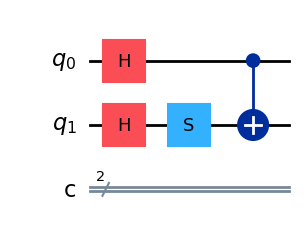

In [15]:
Circuit['q0plus_q1right'].draw(output='mpl') 

In [16]:
job_cnot = {}
for MeasName, Measure in IdealMeasurement.items():
    for CirName, Cir in Circuit.items():
        CirTran = q.compiler.transpile(Cir, backend=backend, optimization_level=0)
        job_cnot.update({f'{CirName}_{MeasName}':estimator.run([(CirTran, Measure)])})

In [17]:
result_cnot_origin = []
for index, job_name in job_cnot.items():
    res = job_name.result()
    result_cnot_origin.append(res[0].data.evs)
g_cnot = np.array(result_cnot_origin).reshape(16, 16)
g_cnot

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00],
       [ 2.33028625e-03,  3.01483787e-03,  9.52577960e-01,
         3.89435614e-03,  4.25431572e-03,  3.27550549e-03,
         9.50196130e-01,  6.17673132e-03, -5.58161268e-03,
         1.06687191e-02,  9.53147778e-01,  8.69836702e-03,
         1.23159504e-02, -2.59294077e-03,  9.52705930e-01,
         1.03465597e-04],
       [ 2.42636360e-03,  8.97800568e-03,  8.28261664e-03,
         9.45724380e-01, -3.53765274e-03, -1.79252351e-03,
        -2.63775953e-03, -9.51533853e-01, -2.43971785e-03,
         1.07716881e-02, -2.40409909e-03,  1.14969030e-03,
         1.71778482e-03, -2.61401796e-03,  4.48940995e-03,
        -9.57374460e-03],
       [ 9.48970125e-01, -9.52810949e

In [18]:
#Calculate Readout Matrix by the quation Uerror = B^-1 * g_cnot * A^-1
ErrorCnot = np.matmul(np.matmul(B_inv, g_cnot), A_inv)
print(ErrorCnot)
ErrorCnot_inv = inv(ErrorCnot)
# print(ErrorCnot_inv)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.75648545e-02  1.01943249e+00 -9.43282267e-05 -2.88655250e-03
   1.73789330e-03 -3.72367568e-04  9.80477277e-03 -1.20919825e-02
   4.83435880e-03 -5.42676641e-03 -1.17303028e-02  1.98153627e-02
  -1.99845997e-03  3.83348894e-03 -1.23371705e-03 -2.36330981e-03]
 [ 3.35879145e-02  1.69520342e-03 -7.17074290e-03 -6.84620636e-03
   4.84962788e-03 -1.02523351e-02  3.59985523e-03 -6.91124126e-03
  -2.99875910e-03  5.27546693e-03 -6.63058351e-03  8.67542473e-03
   5.86661934e-03 -3.66271697e-04  1.01444427e+00 -2.12398050e-03]
 [ 2.99771379e-02  4.48199114e-03 -7.50861077e-03  2.03953637e-03
   2.81674958e-03  2.37638546e-03 -9.60747274e-04 -5.78007488e-03
  -1.58186316e-02  5.86515805e-03 -2.78509586e-03 -5.29941517e-03
  -1.03

In [19]:
import numpy as np
import csv
# 將矩陣存成CSV檔案
filename = 'matrix_ErrorCnot.csv'
np.savetxt(filename, ErrorCnot, delimiter=",", fmt="%.10e")
print(f"矩陣已成功存成CSV檔案：{filename}")

矩陣已成功存成CSV檔案：matrix_ErrorCnot.csv


# Build PTM of the Ideal Ucnot 

In [20]:
#Construct Ideal Ucnot
pauli = ["I", "X", "Y", "Z"]
pauli_pair = {}
for i in pauli:
    for j in pauli:
        pauli_pair.update({f"{i}{j}":np.array(Pauli(f"{i}{j}").to_matrix())})

def evolution(gate, state):
    return np.matmul(np.matmul(gate, state), np.conj(gate).T)
        
Cnot = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0],
                 [0 ,0, 0, 1],
                 [0, 0, 1, 0]])
IdealCnot = np.ones((16,16),  dtype=complex)
i = 0
for index1, matrix1 in pauli_pair.items():
    j = 0
    for index2, matrix2 in pauli_pair.items():
        applycnot = evolution(Cnot, matrix1)
        element = np.matmul(matrix2, applycnot)
        IdealCnot[i][j] = np.round(np.trace(element)/4)
        j+=1
    i+=1 

print(IdealCnot)

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
   0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.

In [21]:
import numpy as np
import csv
# 將矩陣存成CSV檔案
filename = 'matrix_IdealCnot.csv'
np.savetxt(filename, IdealCnot, delimiter=",", fmt="%.10e")
print(f"矩陣已成功存成CSV檔案：{filename}")

矩陣已成功存成CSV檔案：matrix_IdealCnot.csv


In [22]:
#Construct Error channel
LambdaError = np.matmul(inv(IdealCnot), ErrorCnot)
# print(np.round(LambdaError2))
print(LambdaError.real)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.75648545e-02  1.01943249e+00 -9.43282267e-05 -2.88655250e-03
   1.73789330e-03 -3.72367568e-04  9.80477277e-03 -1.20919825e-02
   4.83435880e-03 -5.42676641e-03 -1.17303028e-02  1.98153627e-02
  -1.99845997e-03  3.83348894e-03 -1.23371705e-03 -2.36330981e-03]
 [ 2.51858636e-03 -1.87686633e-03  1.09284421e+00 -8.86462118e-04
   6.02914078e-04 -4.04450369e-03  2.67935666e-03  1.54553314e-02
  -2.14526412e-03  7.80158229e-03 -3.48889051e-03 -1.09564560e-03
   2.98493038e-02 -4.70060723e-04  3.85706755e-02 -3.95666119e-03]
 [-6.13045434e-04  5.14371966e-03 -5.48572675e-04  1.09872072e+00
  -1.20945073e-02  6.63777416e-03 -2.88592092e-03  5.21184631e-03
  -3.66052924e-04  3.63773605e-03 -1.22723887e-02 -8.25434867e-03
   3.12

# Pauli Twirling

In [23]:
pauli_transfer = {}
for channel, matrix in pauli_pair.items():
    new_matrix = evolution(Cnot, matrix)
    for new_channel, comp_matrix in pauli_pair.items():
        if np.array_equal(new_matrix, comp_matrix) or np.array_equal(new_matrix, -comp_matrix):
            pauli_transfer.update({channel:new_channel})
print(pauli_transfer)

{'II': 'II', 'IX': 'IX', 'IY': 'ZY', 'IZ': 'ZZ', 'XI': 'XX', 'XX': 'XI', 'XY': 'YZ', 'XZ': 'YY', 'YI': 'YX', 'YX': 'YI', 'YY': 'XZ', 'YZ': 'XY', 'ZI': 'ZI', 'ZX': 'ZX', 'ZY': 'IY', 'ZZ': 'IZ'}


In [24]:
# Function to generate measurement circuits
def generate_pauli_circuits(index):
    circuits = {
        "I": QuantumCircuit(2, 2),
        "X": QuantumCircuit(2, 2),
        "Y": QuantumCircuit(2, 2),
        "Z": QuantumCircuit(2, 2),
    }
    # X-measurement
    circuits["X"].x(index)
    # Y-measurement
    circuits["Y"].y(index)
    # Z-measurement
    circuits["Z"].z(index)

    return circuits

# Store the measurement circuits in a dictionary
PauliTwirling = {}
for q0_label, q0 in generate_pauli_circuits(0).items():
    for q1_label, q1 in generate_pauli_circuits(1).items():
        pauli_comb = q.circuit.QuantumCircuit.compose(q0, q1)
        PauliTwirling.update({f"{q0_label}{q1_label}": pauli_comb})
print(PauliTwirling)

{'II': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7af96421ac60>, 'IX': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7af964219040>, 'IY': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7af96421b5c0>, 'IZ': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7af96421aa80>, 'XI': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7af96421a5d0>, 'XX': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7af96421a4e0>, 'XY': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7af96421a3f0>, 'XZ': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7af96421a300>, 'YI': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7af964219e50>, 'YX': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7af964219d60>, 'YY': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7af964219c70>, 'YZ': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7af964219b80>, 'ZI': <qiskit.circuit.quantumcircuit.QuantumCircuit

In [25]:
Twirling_circuit_set = {}
for firstPauli, secondPauli in pauli_transfer.items():
    Twirling_circuit = {}
    for InitName, Initial in InitialState.items():
        AddPauli = q.circuit.QuantumCircuit.compose(Initial, PauliTwirling[firstPauli])
        AddCnot = q.circuit.QuantumCircuit.compose(AddPauli, Cnotgate)
        AddPauliInverse = q.circuit.QuantumCircuit.compose(AddCnot, PauliTwirling[secondPauli])
        Twirling_circuit.update({InitName:AddPauliInverse})
    Twirling_circuit_set.update({firstPauli:Twirling_circuit})

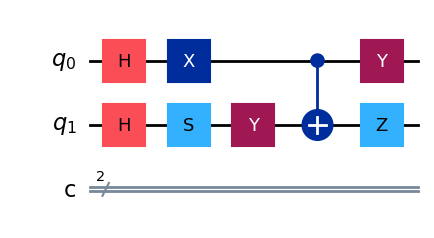

In [26]:
Twirling_circuit_set['XY']['q0plus_q1right'].draw(output='mpl') 

In [27]:
Twirling_job = {}
for pauli, circuit_set in Twirling_circuit_set.items():
    job = {}
    for MeasName, Measure in IdealMeasurement.items():
        for CirName, Cir in circuit_set.items():
            CirTran = q.compiler.transpile(Cir, backend=backend, optimization_level=0)
            job.update({f'{CirName}_{MeasName}':estimator.run([(CirTran, Measure)])})
    Twirling_job.update({pauli:job})

In [28]:
Sum_twirling = np.zeros((16,16))
for pauli, job_set in Twirling_job.items():
    result_each_twirling = []
    for index, job_name in job_set.items():
        res = job_name.result()
        result_each_twirling.append(res[0].data.evs)
    g_twirling = (np.array(result_each_twirling).reshape(16, 16))
    ErrorCnot_twirling = np.matmul(np.matmul(B_inv, g_twirling), A_inv)
    Sum_twirling = Sum_twirling + ErrorCnot_twirling

Avg_twirling = Sum_twirling/16
Avg_gateError = np.matmul(inv(IdealCnot), Avg_twirling)
Avg_gateError

array([[ 1.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
         0.00000000e+00+0.j],
       [ 3.52804584e-02+0.j,  1.02211436e+00+0.j, -1.60166135e-03+0.j,
        -5.75693942e-03+0.j,  5.90572767e-03+0.j, -8.86267067e-03+0.j,
         7.21358776e-03+0.j, -6.97056531e-03+0.j,  6.54553594e-03+0.j,
        -1.12167851e-02+0.j, -1.13574153e-02+0.j,  2.34942754e-02+0.j,
        -2.45817683e-03+0.j,  3.55305956e-03+0.j, -1.63434228e-03+0.j,
        -4.89376875e-03+0.j],
       [ 1.14900265e-03+0.j, -8.94042722e-04+0.j,  1.09387213e+00+0.j,
        -1.24831858e-03+0.j,  4.69969275e-03+0.j, -7.47677282e-04+0.j,
         2.43540157e-04+0.j,  7.65261208e-03+0.j,  6.57541841e-04+0.j,
         4.291728

In [29]:
def OutputMatrix(matrix, filename):
    # 將每列轉為空格分隔的字串
    matrix_lines = [''.join(f"{val:>9.5f}" for val in row) for row in matrix]
    
    # 繪製圖片
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.axis('off')  # 不顯示座標軸
    
    # 建立表格
    table_data = []
    for i in range(16):
        row = []
        for j in range(16):
            val = matrix[i][j]
            formatted = f"{val.real:.6f}"
            row.append(formatted)
        table_data.append(row)
    
    # 建立表格物件
    table = ax.table(cellText=table_data,  loc='center',  cellLoc='center')
    
    # 樣式調整
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            cell = table[i, j]
            val = matrix[i][j]
            
            # 主對角線粗體
            if 0.8 <= abs(val) < 1.2:
                cell.set_text_props(weight='bold')
    
            # 紅色標註：介於 0.01 ~ 0.1 或 -0.01 ~ -0.1
            if 0.01 <= abs(val) < 0.1:
                cell.set_text_props(color='red')
    
    # 儲存為圖片
    plt.savefig(f"{filename}.png", bbox_inches='tight', dpi=300)
    plt.close()

In [30]:
OutputMatrix(Avg_gateError, "Avg_gateError_1Wshots")

In [31]:
import numpy as np
import csv
# 將矩陣存成CSV檔案
filename = 'matrix_TwirlingError.csv'
np.savetxt(filename, Avg_gateError, delimiter=",", fmt="%.10e")

In [32]:
# 重新初始化結果陣列
result = np.zeros(16, dtype=complex)

#  
for i in range(16):
    result[i] += Avg_gateError[i, i]
result = result.reshape(16, 1)
result

array([[1.        +0.j],
       [1.02211436+0.j],
       [1.09387213+0.j],
       [1.10039052+0.j],
       [1.09051076+0.j],
       [1.0248063 +0.j],
       [1.10463199+0.j],
       [1.09132303+0.j],
       [1.07444097+0.j],
       [1.02221507+0.j],
       [1.10140495+0.j],
       [1.0881968 +0.j],
       [1.02081553+0.j],
       [1.1012567 +0.j],
       [1.0193056 +0.j],
       [1.01910168+0.j]])

In [33]:
P = np.array([[1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],\
              [1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1],\
              [1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1],\
              [1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1],\
              [1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1],\
              [1,  1, -1, -1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1],\
              [1, -1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1],\
              [1, -1, -1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1, -1],\
              [1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1],\
              [1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1],\
              [1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1],\
              [1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1],\
              [1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1],\
              [1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1],\
              [1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1, -1],\
              [1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1]])
P

array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1],
       [ 1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1],
       [ 1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1],
       [ 1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 1,  1, -1, -1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,  1],
       [ 1, -1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,  1, -1,  1],
       [ 1, -1, -1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1, -1],
       [ 1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1],
       [ 1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1],
       [ 1, -1,  1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1],
       [ 1, -1, -1,  1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1,  1, -1],
       [ 1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1],
       [ 1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1,

In [34]:
weight_c = np.matmul(inv(P), result)
weight_c

array([[ 1.06089915e+00+0.j],
       [-1.63791893e-02+0.j],
       [ 2.22359153e-03+0.j],
       [-3.01738471e-04+0.j],
       [ 5.05698521e-03+0.j],
       [-1.52190924e-02+0.j],
       [ 4.07399187e-03+0.j],
       [ 4.90168081e-03+0.j],
       [ 1.93020138e-03+0.j],
       [-1.67575617e-02+0.j],
       [ 2.37656983e-03+0.j],
       [ 3.22946053e-03+0.j],
       [-1.37920843e-02+0.j],
       [ 5.31877099e-03+0.j],
       [-1.58323411e-02+0.j],
       [-1.17283940e-02+0.j]])

In [35]:
# 重新初始化結果陣列
inv_result = np.zeros(16, dtype=complex)

#  
for i in range(16):
        inv_result[i] += inv(Avg_gateError)[i, i]
inv_result = inv_result.reshape(16, 1)
inv_result

array([[1.        +0.j],
       [0.97866405+0.j],
       [0.91418645+0.j],
       [0.9087941 +0.j],
       [0.91708638+0.j],
       [0.97559379+0.j],
       [0.90532825+0.j],
       [0.91581484+0.j],
       [0.92996599+0.j],
       [0.9772707 +0.j],
       [0.90771239+0.j],
       [0.91863427+0.j],
       [0.97964351+0.j],
       [0.90803161+0.j],
       [0.98127899+0.j],
       [0.98126722+0.j]])

In [36]:
inv_weight_c = np.matmul(inv(P), inv_result)
inv_weight_c

array([[ 9.43704533e-01+0.j],
       [ 1.45774700e-02+0.j],
       [-1.80428861e-03+0.j],
       [ 1.96254119e-04+0.j],
       [-4.27105111e-03+0.j],
       [ 1.38251036e-02+0.j],
       [-3.47892376e-03+0.j],
       [-4.20590791e-03+0.j],
       [-1.80104075e-03+0.j],
       [ 1.49942218e-02+0.j],
       [-2.13299757e-03+0.j],
       [-2.75115727e-03+0.j],
       [ 1.27787066e-02+0.j],
       [-4.47591859e-03+0.j],
       [ 1.40982849e-02+0.j],
       [ 1.07467115e-02+0.j]])

In [37]:
Twirling_test_circuit_set = {}
for InitName, Initial in InitialState.items():
    Twirling_test_circuit = {}
    for firstPauli, secondPauli in pauli_transfer.items():
        AddPauli = q.circuit.QuantumCircuit.compose(Initial, PauliTwirling[firstPauli])
        AddCnot = q.circuit.QuantumCircuit.compose(AddPauli, Cnotgate)
        Twirling_test_circuit.update({firstPauli:AddCnot})
    Twirling_test_circuit_set.update({InitName:Twirling_test_circuit})

In [38]:
Twirling_test_job = {}
for MeasName, Measure in IdealMeasurement.items():
    for InitName, circuit_set in Twirling_test_circuit_set.items():
        job = {}
        for pauli, Cir in circuit_set.items():
            CirTran = q.compiler.transpile(Cir, backend=backend, optimization_level=0)
            job.update({pauli:estimator.run([(CirTran, Measure)])})
        Twirling_test_job.update({f'{InitName}_{MeasName}':job})

In [39]:
Twirling_test_job

{'q0zero_q1zero_measII': {'II': <qiskit.primitives.primitive_job.PrimitiveJob at 0x7af8c7041b50>,
  'IX': <qiskit.primitives.primitive_job.PrimitiveJob at 0x7af8c7042550>,
  'IY': <qiskit.primitives.primitive_job.PrimitiveJob at 0x7af8c699e850>,
  'IZ': <qiskit.primitives.primitive_job.PrimitiveJob at 0x7af8c674c550>,
  'XI': <qiskit.primitives.primitive_job.PrimitiveJob at 0x7af8c6b69850>,
  'XX': <qiskit.primitives.primitive_job.PrimitiveJob at 0x7af8c68e9750>,
  'XY': <qiskit.primitives.primitive_job.PrimitiveJob at 0x7af8c68e9550>,
  'XZ': <qiskit.primitives.primitive_job.PrimitiveJob at 0x7af8c6c8b650>,
  'YI': <qiskit.primitives.primitive_job.PrimitiveJob at 0x7af8c6c8a850>,
  'YX': <qiskit.primitives.primitive_job.PrimitiveJob at 0x7af8c6da03d0>,
  'YY': <qiskit.primitives.primitive_job.PrimitiveJob at 0x7af8c674e850>,
  'YZ': <qiskit.primitives.primitive_job.PrimitiveJob at 0x7af8c69026d0>,
  'ZI': <qiskit.primitives.primitive_job.PrimitiveJob at 0x7af8c70417d0>,
  'ZX': <qiski

In [40]:
g_twirling = []
for index, job_name in Twirling_test_job.items():
    average_result = 0
    i = 0
    for pauli, job_set in job_name.items():
        res = job_set.result()
        average_result = average_result + res[0].data.evs * inv_weight_c[i]
        i += 1
    # print(average_result)
    g_twirling.append(average_result)
g_twirling = np.array(g_twirling).reshape(16, 16)
Cnot_twirling = np.matmul(np.matmul(B_inv, g_twirling), A_inv)
print('g:\n', g_twirling)
print('Cnot:\n', Cnot_twirling)

g:
 [[ 1.00000000e+00+0.j  1.00000000e+00+0.j  1.00000000e+00+0.j
   1.00000000e+00+0.j  1.00000000e+00+0.j  1.00000000e+00+0.j
   1.00000000e+00+0.j  1.00000000e+00+0.j  1.00000000e+00+0.j
   1.00000000e+00+0.j  1.00000000e+00+0.j  1.00000000e+00+0.j
   1.00000000e+00+0.j  1.00000000e+00+0.j  1.00000000e+00+0.j
   1.00000000e+00+0.j]
 [ 2.14170415e-03+0.j  8.61649437e-03+0.j  9.31592550e-01+0.j
   1.24226712e-03+0.j  2.39760673e-03+0.j  5.56179445e-04+0.j
   9.31719497e-01+0.j  7.76197832e-03+0.j -2.79805125e-03+0.j
   4.92729760e-03+0.j  9.28600777e-01+0.j  3.21752380e-03+0.j
   1.60287862e-02+0.j -9.06658502e-03+0.j  9.28188300e-01+0.j
  -1.69092699e-03+0.j]
 [-5.75606245e-03+0.j  2.46763702e-03+0.j -4.85983458e-03+0.j
   9.30964863e-01+0.j -8.27955684e-03+0.j  1.59836433e-03+0.j
   7.15407224e-04+0.j -9.33578587e-01+0.j -2.77560574e-03+0.j
   4.13371509e-03+0.j  2.52920830e-03+0.j  4.48792674e-03+0.j
  -3.00500134e-03+0.j  2.45412940e-03+0.j  1.85756401e-03+0.j
  -6.16361672e-03+0.